## Introduction to Low-Level Image Processing

You can get a long way in image processing and computer vision with
fairly simple operations that basically just work with arithmetic.
They're not only easier to use than more complex algorithms, but 
also usually faster, easier to inspect, and more reliable than 
complex algorithms. 

It's good to understand low-level techniques if you think you might want 
to use more complex techniques for image recognition or processing, 
including machine learning methods, because complex techniques often 
don't work well without preprocessing by simpler functions. Simple 
functions can also be assembled into quite complex ones!

In those notebook, we'll primarily be using "morphological" operations 
-- operations that work with line, shape, and form. However, we'll start
with a little introduction to their extended family.

### Footprint Operations

Many image manipulation techniques rely on looking at each pixel in the 
image, then applying some kind of mathematical function to the pixels 
that fall within some region around it. This region is called a "footprint"
(or sometimes a "kernel").  

Let's look briefly at a useful _non_-morphological example of this
technique: the median filter. This filter works by replacing each pixel 
in an image with the median value of the pixels that fall within a footprint
around it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
# NOTE: I don't remember if we opened 'desktop' images before.
from PIL import Image
import scipy.ndimage as ndi
# This is a little settings file that removes all the annoying
# borders and axes and things that aren't really relevant
# when we're just using matplotlib to look at things as images.
plt.style.use('settings/simple_image.mplstyle')

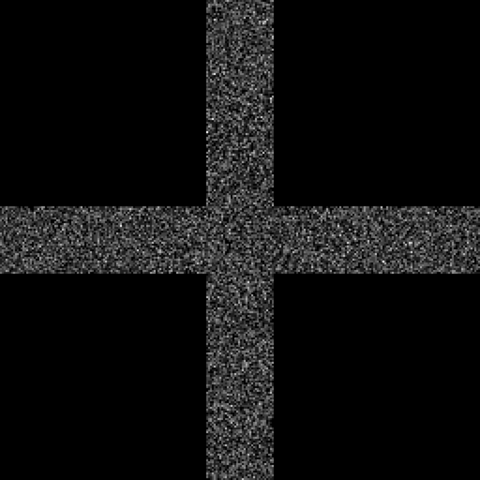

In [2]:
# load in a noisy cross shape.
noisecross = np.asarray(Image.open('images/noisecross.png'))
_ = plt.imshow(noisecross)

In [3]:
# generate big and small footprints.
# note that what's 'big' and 'small' depends on the
# size of the image you're applying a filter to!
fbig, fsmall = 10, 3
big_foot, small_foot = np.ones((fbig, fbig)), np.ones((fsmall, fsmall))
# these are just arrays:
small_foot

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

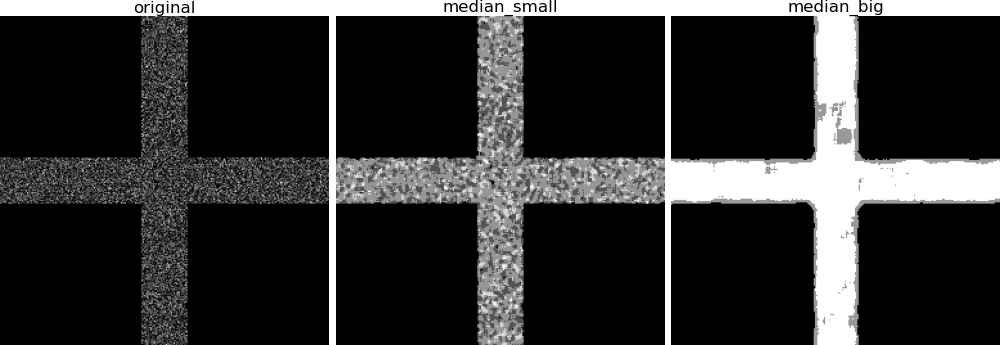

In [4]:
# The median filter has a 'softening' effect. When the footprint is small, the 
# softening is relatively mild; as it gets bigger, the softening gets more intense.
# This is a little bit like turning up the bass on a piece of music: it emphasizes
# more consistent parts of the image and suppresses more variable ones.
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes[0].imshow(noisecross)
axes[1].imshow(ndi.median_filter(noisecross, footprint=small_foot))
axes[2].imshow(ndi.median_filter(noisecross, footprint=big_foot))
for i, title in zip((0, 1, 2), ("original", "median_small", "median_big")):
    axes[i].set_title(title)

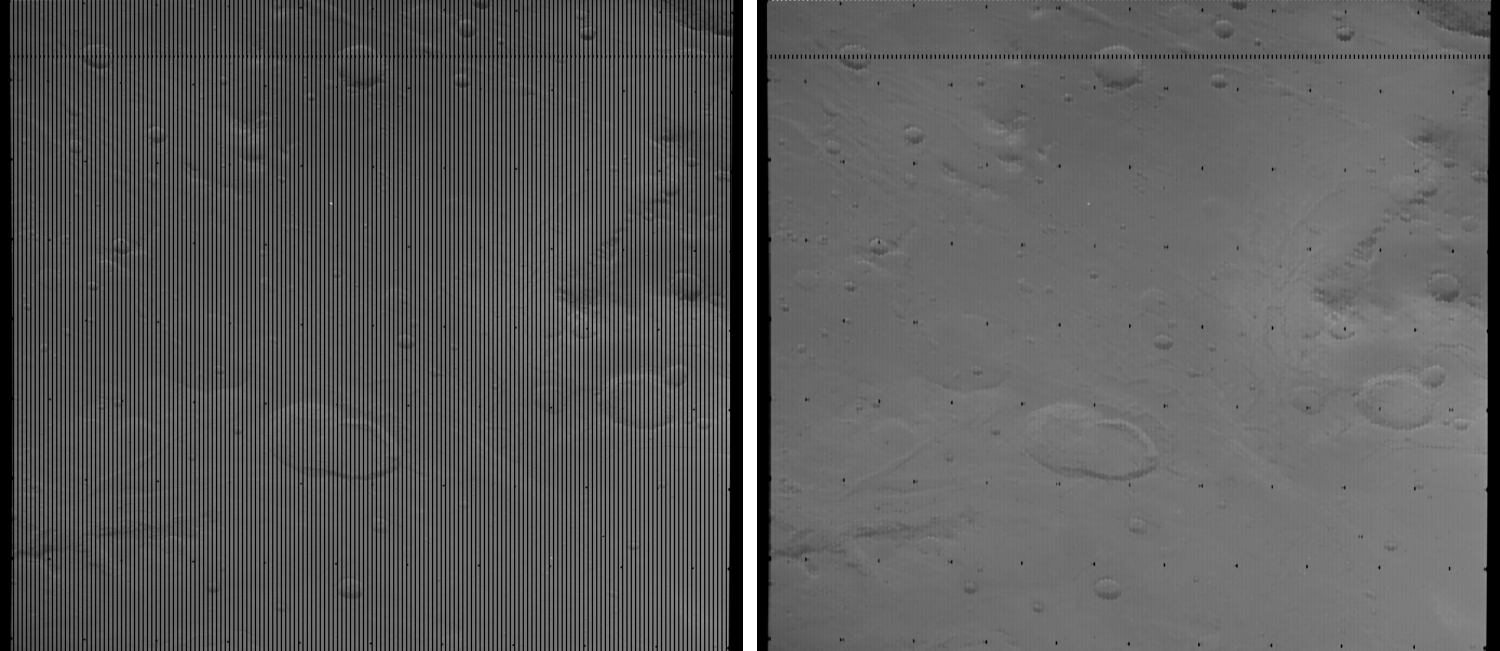

In [5]:
# This can be used for many practical purposes. For instance, look 
# at what a median filter can do to the scanlines in this classic Viking Orbiter image
# (a technique the ground team used to great advantage!):
import pdr
viking = pdr.read("/datascratch/viking/edr/vo_1023/f611axx/F611A13.IMG").IMAGE
fig, axes = plt.subplots(1, 2, figsize=(15, 9))
axes[0].imshow(viking)
axes[1].imshow(ndi.median_filter(viking, footprint=np.ones((4, 4))))

## Morphological Operators

Because subjective fullness of the Moon is basically about shape and line,
we'd like to be able to work directly with those aspects of images. 
Morphological operators are powerful tools for doing this. Morphological
operators are a type of footprint-based filter that use logical operations
like "and" and "or" instead of arithmetic.

### Making Binary Images

Because they do true/false logic, morphological operators want to work on
"binary" images -- black-and-white images made up of only 1s and 0s.

Most images we want to work with don't start out as binary images. The
easiest (and one of the most effective) ways to reduce images to lines
is to set a cutoff value or "threshold". We then set all values below
that threshold to black, and all values above that threshold to white. 
If it's a color image, we also want to turn it to grayscale first.
This often works something like tracing or making an outline of an image --
and these are also good first steps in other processes that want outlines,
like silkscreening.

Let's go ahead and walk through the process.

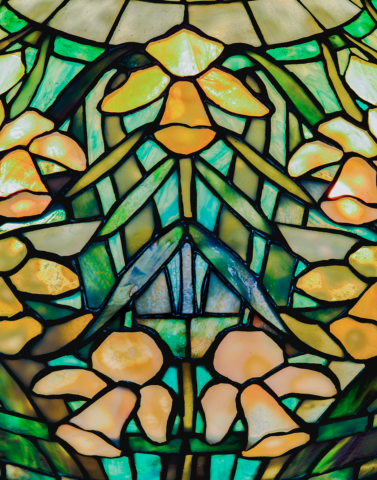

In [6]:
# Here is a detail of part of a Tiffany lamp.
tiffany = np.asarray(Image.open("images/tiffany.png"))
plt.imshow(tiffany)

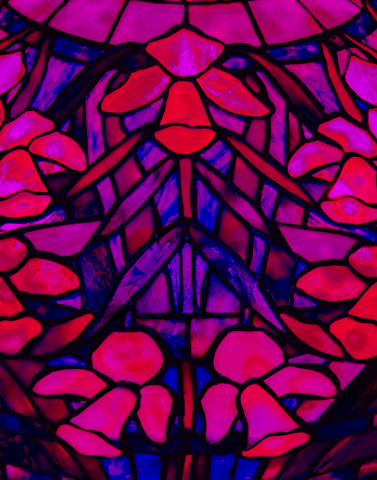

In [7]:
# Color images are usually 3-D arrays where the third axis
# represents color channel, in this case red (R), green (G) or blue (B).
# This would make a purple version of the image:
purple_tiffany = tiffany.copy()
purple_tiffany[:, :, 1] = 0
plt.imshow(purple_tiffany)

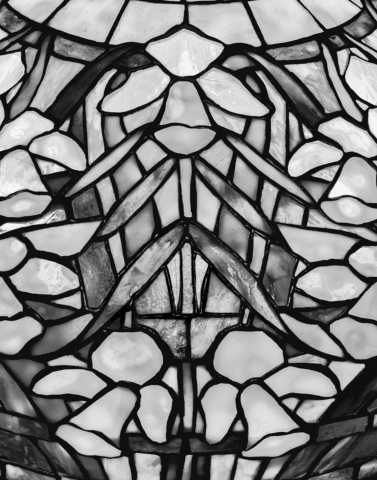

In [8]:
# This means that the easiest way to make a gray version of a color image
# is just to merge its channels down:
tiffany_gray = np.median(tiffany, axis=2)
plt.imshow(tiffany_gray)

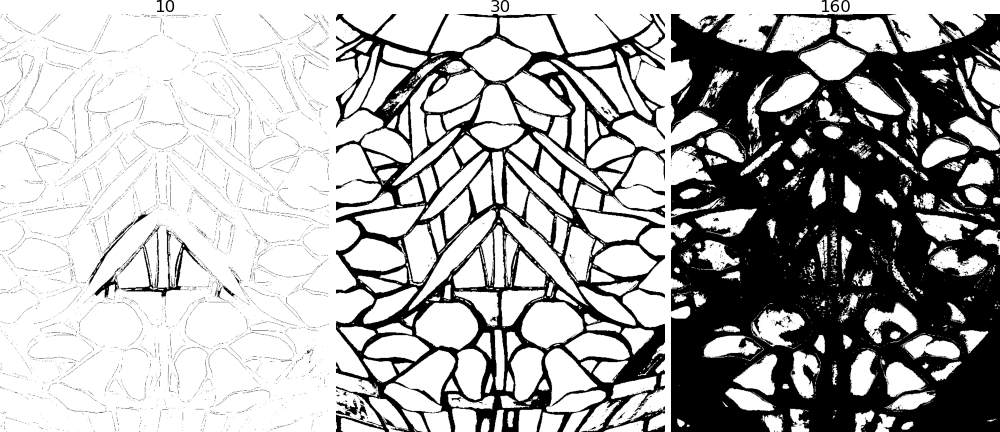

In [9]:
# We can now turn it to a black-and-white image with thresholding.
# Picking the correct threshold value is a little bit of an art and
# depends on exactly what features you want the outline to
# retain. Let's see what happens at a few different levels...
fig, axes = plt.subplots(1, 3, figsize=(10, 8))
threshold_levels = (10, 30, 160)
for i, level in enumerate(threshold_levels):
    axes[i].imshow(tiffany_gray > level)
    axes[i].set_title(level)

In [10]:
# Let's go ahead and pick the middle value for our outline.
tiffany_outline = tiffany_gray > 30

### Dilation and Erosion

There are two basic morphological operators: erosion and dilation. Most
other can be assembled from combinations of these two.

Dilation is an "or". If there is a pixel valued 1 anywhere in the dilation 
operator's footprint, it sets the center pixel to 1; otherwise, it sets it
to 0. Erosion is an "and": if _all_ pixels in the erosion operator's 
footprint are 1, it sets the center pixel to 1; otherwise, it sets the
center pixel to 0.

This means that erosion will tend to make black parts of the image heavier,
thicker, and more coherent, and dilation will do the opposite.

Let's look at erosion and dilation here. Note that, just like the median filter 
we saw earlier, bigger footprints tend to make morphological operatorsand selecting the correct footprint size
or shape for particular images and applications can be a very finicky job. "stronger". 

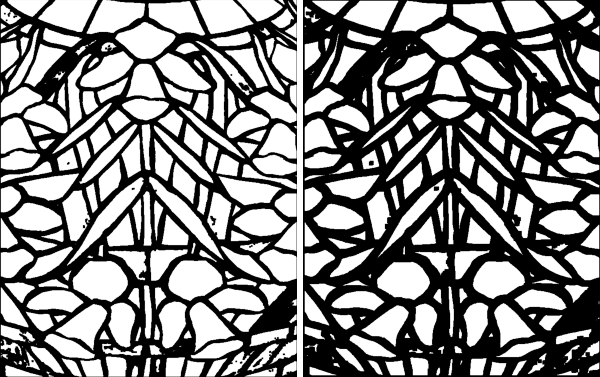

In [11]:
# Because this particular image is basically a black-on-white outline, erosion 
# will tend to make its lines thicker and its sections more distinct:
small, big = 4, 9
fig, axes = plt.subplots(1, 2, figsize=(6, 8))
for i, size in enumerate((small, big)):
    footprint = np.ones((size, size))
    axes[i].imshow(ndi.binary_erosion(tiffany_outline, footprint))

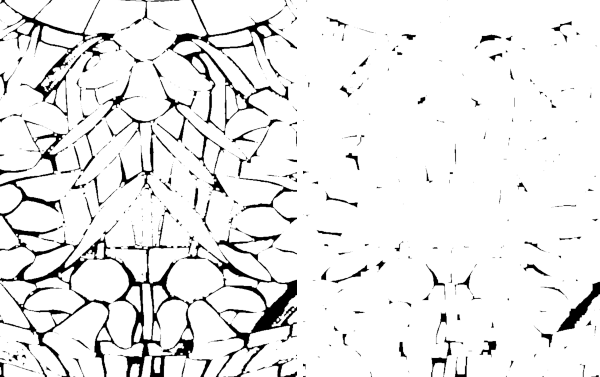

In [12]:
# Whereas dilation will tend to make its lines thinner and blur sections:
fig, axes = plt.subplots(1, 2, figsize=(6, 8))
for i, size in enumerate((small, big)):
    footprint = np.ones((size, size))
    axes[i].imshow(ndi.binary_dilation(tiffany_outline, footprint))

### Labeling

Being able to manipulate lines like this is very useful in part because it
lets us automatically segment images. The simplest way to do this is to
simply find contiguous regions of the image and assign a unique number to 
them. This process is called "labeling", and many good tools for it exist
in Python.

In the next cell, you'll 'thicken' the Tiffany outline and then use `ndi.label()` 
to assign every contiguous 1-valued region of that outline its own unique number.
It always assigns 0 to what it identifies as "background". 
You'll see that it doesn't work perfectly -- it may cut some sections at the 
edges off, and can't quite distinguish some regions that might look contiguous to 
your eye because of some junky little line bits that connect them.

Like threshold levels, selecting good footprint sizes and shapes for particular images
and applications can be a very finicky job. If you change the footprint size
from (3, 3) and run the cell again, you will see that you get quite different labels.
If you make it a lot bigger, you'll see that you get _fewer_ labels, because the erosion
will have made image areas more distinct from one another...although if you make it big 
enough, you might not get any at all, because you'll have eroded all the lines into one
big line.

237 labels found.


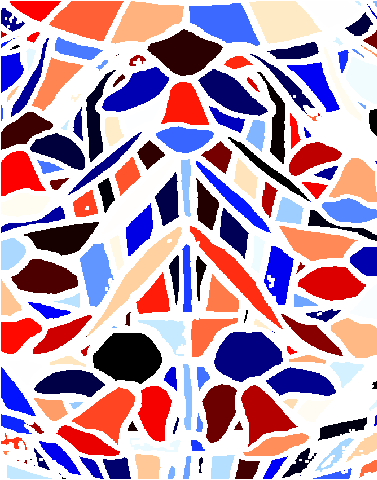

In [222]:
trace = ndi.binary_erosion(tiffany_outline, np.ones((5, 5)))
labels, n_labels = ndi.label(trace)
print(f"{n_labels} labels found.")
plt.imshow(np.ma.masked_where(labels == 0, labels), cmap='flag', interpolation='none')

We can use this to pick out, count, and locate individual
regions of an image. Try running this next cell a few times to drill
down into the specific image elements our little algorithm identified.
You'll note that not every label is interesting -- `ndi.label()`
will happily assign a unique label to a tiny little dot, as long
as it's isolated. When we look at lunar images a little later, 
we'll need to watch for that fact.

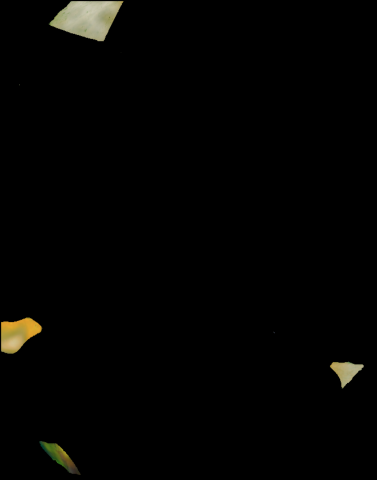

In [241]:
# Utility functions for visualization.

def apply_2d_stencil(color_image, stencil_2d):
    # reshape `stencil_2d` to fit the 3D color image
    stencil_3d = np.moveaxis(np.tile(stencil_2d, (3, 1, 1)), 0, 2)
    # return a 3D array that contains the original pixels where 
    # `stencil_2d` is truthy, and is black elsewhere
    return np.where(stencil_3d, color_image, 0)

def labelstencil(color_image, label_array, label_numbers):
    """
    Return a copy of `color_image` blacked out wherever the values of 
    `label_array` don't fall within `label_numbers`.
    """
    # make an array that's True for these labels and false otherwise
    return apply_2d_stencil(color_image, np.isin(label_array, label_numbers))


# select 8 random numbers from among all labels, not counting the 
# 0/background label.
random_label_choices = np.random.choice(range(1, n_labels), 8)
plt.imshow(labelstencil(tiffany, labels, random_label_choices))

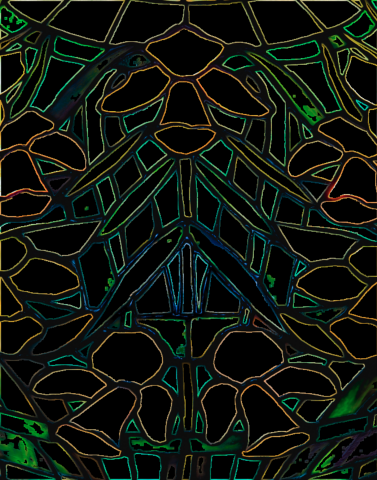

In [242]:
# you can also look at just the background:
plt.imshow(labelstencil(tiffany, labels, [0]))

### Getting shapes from labels **[TODO: bad title]**

Because of image defects and the messy imperfection of the world,
labels don't usually _exactly_ fit the regions you'd like to find
in images, and there are many techniques for helping them better fit 
the kind of shapes you're looking for. Taking a label's
_convex hull_ is one of the most straightforward and frequently-useful
techniques. Informally, a convex hull is the smallest shape you can draw 
around a set of points without leaving any dents or holes. Of course,
sometimes the regions you're looking for _aren't_ convex, in which case
this might not be appropriate -- but it is practically and analytically
useful in many cases. OpenCV's `convexHull()` function provides an easy
way to do this. OpenCV also has useful methods for fitting the points
produced by `convexHull()` inside of circles, squares, etc. OpenCV has
an excellent Python API called `cv2`, but its expectations and behavior 
can be a little surprising. The next cell contains a couple of little 
wrappers for finding the convex hull of the shape implied by a binary
array, finding the minimum enclosing circle for a `cv2`-produced convex 
hull, and visualizing them.

In [297]:
cv2.minEnclosingCircle(np.zeros((10, 10), dtype=np.uint32))

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'minEnclosingCircle'
> Overload resolution failed:
>  - points data type = 6 is not supported
>  - Expected Ptr<cv::UMat> for argument 'points'


In [298]:
def bool2cv(arr):
    """
    Converts the truthy elements of an ndarray into an array of "vectors"
    suitable for use by OpenCV geometry functions.
    """
    return np.vstack(*np.nonzero(arr)).T

In [293]:
cv2.minEnclosingCircle(np.vstack([y, x]).T)

((22.0, 152.0), 68.96385955810547)

In [ ]:
    return cv2.circle(canvas, center, radius, (0, 255, 255), 2)

In [ ]:
import cv2

def gethull(blob: np.ndarray) -> np.ndarray:
    """
    Compute the convex hull of the "shape" contained in `blob`, which should be
    a 2D ndarray of 8-bit unsigned integers valued either 0 or 1; 1 represents
    "foreground". Returns a 2D ndarray whose rows are the vertices of the hull
    and whose 2 columns represent the X and Y indices of each vertex.
    """
    return np.flip(cv2.convexHull(np.vstack(np.nonzero(blob)).T), axis=2)


def 


    # center, radius = cv2.minEnclosingCircle(hull)



# Now, this just returns a bunch of points, which `
gethull(labels == 2)

In [266]:
len(np.nonzero(labels == 23)[0])

1776

# 

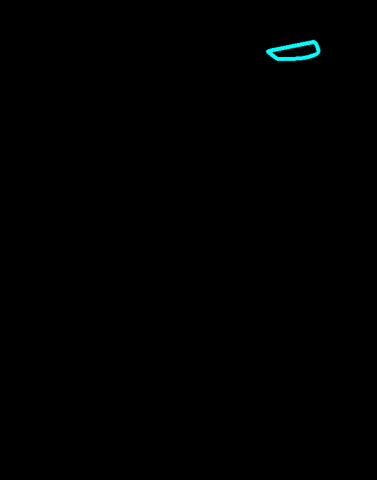

In [283]:

plt.imshow(
    cv2.drawContours(np.zeros((*labels.shape, 3)), [gethull(labels == 26)], -1, (0, 1, 1), 5), interpolation=None
)

# SECTIONS SECTIONS SECTIONS

# Moon fullness identification algorithm

## Assumptions

These are not completely true, but good enough for the algorithm:
1. A full Moon looks like a perfect circle.
2. The only things that ever appear in the GOES LUN images are stars, the Moon, the Earth, and static.
3. The Earth will always appear as a contiguous region that touches at least one image edge.
4. If the Moon touches an image edge, we can ignore it, because we won't be able to tell how full
   it is anyway.
5. The images are taken at about the same distance from the Moon, so the Moon will fall within a
   small size range.
6. There are no legitimate images of the Moon at less than half full in this set, so we can
   always assume the Moon label is convex.

## Steps

Given those assumptions, we can perform the following steps to figure out how full
the Moon looks in a GOES image:

1. Turn the image into an outline using thresholding.
2. Apply an erosion operator to the outline to clean up static, stars, and imaging imperfections.
3. Label the eroded outline.
4. Exclude labels that are:
    1. the wrong size
    2. too close to an image edge
5. If we have exactly one label left, it's the Moon; proceed to step 6. Otherwise, there's no Moon in the image.
6. Apply a dilation operator to smooth the edges of the Moon label, and then 
7. Draw a circle around the label. The ratio of the area of that circle to the That ratio is
   fullness.

In [ ]:
import cv2
import numpy as np
import scipy.ndimage as ndi
from typing import Union

def a2c(area: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """Area of a circle."""
    return 2 * np.pi * np.sqrt(area / np.pi)



def filter_labels(
    arr: np.ndarray, 
    labels: np.ndarray, 
    bordersize: int, 
    min_moon_extent: int
) -> tuple[dict, dict, dict]:
    """
    Filter 'bad' labels: labels that are too small or that come 
    within a specified range of the top/bottom/left/right of the image.
    """
    label_indices = {
        label: np.nonzero(labels == label)
        for label in np.unique(labels)
        if label != 0
    }
    label_rejects = {}
    for label, (yix, xix) in label_indices.items():
        if min([np.ptp(xix), np.ptp(yix)]) < min_moon_extent:
            label_rejects[label] = 'small'
        elif (xix <= bordersize).any():
            label_rejects[label] = 'left'
        elif (arr.shape[1] - xix <= bordersize).any():
            label_rejects[label] = 'right'
        elif (yix <= bordersize).any():
            label_rejects[label] = 'top'
        elif (arr.shape[0] - yix <= bordersize).any():
            label_rejects[label] = 'bottom'
    remaining = {
        k: v for k, v in label_indices.items()
        if k not in label_rejects.keys()
    }
    return remaining, label_rejects, label_indices


def moon_extraction_error(rec: dict, n_remaining: int) -> dict:
    if n_remaining == 0:
        return rec | {'error': 'no Moon', 'moon': None}
    if n_remaining > 1:
        return rec | {'error': 'ambiguous Moon', 'moon': None}
    raise ValueError("How did we get here?")


def get_moon_cutout(remaining: dict, moonpad: int) -> list[slice]:
    moon_y, moon_x = next(iter(remaining.values()))
    y0, y1, x0, x1 = moon_y.min(), moon_y.max(), moon_x.min(), moon_x.max()
    return [
        slice(max(y0 - moonpad, 0), y1 + moonpad),
        slice(max(x0 - moonpad, 0), x1 + moonpad)
    ]


def mooncircle(labels, moonslice, moonlabel) -> dict:
    """
    Given a dict containing a label array (keyed "labels") and a tuple of
    Y/X slices giving the bounds of a detected "Moon" (keyed "moonlabel"),
    compute the convex hull of the detected Moon, and approximate its
    illuminated fraction by comparing the area of that hull to the area of its
    minimum enclosing circle (which represents an implied full Moon).
    """
    moonblob = labels[*moonslice] == moonlabel
    smoothblob = ndi.binary_dilation(moonblob, np.ones((5, 5))).astype('u1')
    hull = gethull(smoothblob)
    center, radius = cv2.minEnclosingCircle(hull)
    return {
        'smoothblob': smoothblob,
        'center': center,
        'radius': radius,
        'ratio': cv2.contourArea(hull) / (np.pi * radius ** 2)
    }
    

# TODO: don't magically provide good parameters. make them mess with it.
def extract_moon(
    arr: np.ndarray,
    threshold: float = 0.7,
    erosion: int = 4,
    bordersize: int = 50,
    moonpad: int = 60,
    min_moon_extent: int = 180,
    extended: bool = False
) -> dict:
    """
    Attempt to identify/locate a Moon in a 2D array taken from a GOES LUN
    radiance image. Takes a number of parameters for different steps of the
    extraction pipeline:
    * threshold: cutoff value for making initial threshold array
    * erosion: side length of square footprint for erosion operator applied
      to threshold array
    * bordersize: image border width for top/bottom/left/right label rejection
    * moonpad: number of "padding" pixels to add to the Moon cutout
    * min_moon_extent: minimum extent, along both X and Y axes, for identifying
      a label as the Moon
    * extended: return extended information?

    TODO: internal documentation, split out, explain, blah blah
    """
    morph = (arr.filled(0) > threshold)
    if erosion is not None:
        morph = ndi.binary_erosion(morph, np.ones((erosion, erosion)))
    morph = morph.astype('u1')
    labels, n_labels = ndi.label(morph)
    remaining, label_rejects, label_indices = filter_labels(
        arr, labels, bordersize, min_moon_extent
    )
    rec = {'n_labels': n_labels, 'reject_reasons': label_rejects}
    if extended is True:
        rec |= {'labels': labels, 'label_indices': label_indices}
    if len(remaining) != 1:
        return moon_extraction_error(rec, len(remaining))
    moonlabel = next(iter(remaining.keys()))
    moonslice = get_moon_cutout(remaining, moonpad)
    rec |= mooncircle(labels, moonslice, moonlabel)
    if extended is True:
        rec['moonlabel'] = moonlabel
        rec['moonslice'] = moonslice
    return rec | {'error': None, 'moon': arr[*moonslice]}